Feature Scaling, different padding, cross validation, take part data, different accuracies, more refining of pattern, visual inspection of chunks, increase data size...

--drop less than 5 or 6, moving average, scaling voltage with 48, formula value instead of hardcoding

In [1]:
#from sklearn.preprocessing import StandardScaler

# Seed value
# Apparently we may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
import sys
import os

In [3]:
def add_chunk_to_group_single(df):
    df["speed"] = df["speed"].astype(float)
    
    #checking if speed >=25 and making it 0
    #df.loc[df['speed'] >=255, 'speed'] = 0
    #df.loc[df['altitude'] >=4000, 'altitude'] = 0
    
    df["main_bat"] = df["main_bat"].astype(float)
    meanspeed = df["speed"].mean()
    meanspeed = 1
    df["speed"] = df["speed"]/meanspeed
    #df["speed"] = df["speed"].rolling(window=1).mean()
    mean_bat = df["main_bat"].mean()
    mean_bat = 1
    df["main_bat"] = df["main_bat"]/mean_bat
    #df["main_bat"] = df["main_bat"]*2
    df["main_bat"] = df["main_bat"].rolling(window=2).mean()
    df = df.fillna(0)
    inner_list = list()
    inner_list_debug = list()
    start_speed = 6/meanspeed
    start_chunk=1
    start_pad =1
    hang_count_max=1
    hangover_count=hang_count_max
    max_speed = 3/meanspeed
    min_chunk_len = 6
    
    
    for index, row in df.iterrows():
        if(row.speed>=start_speed and start_chunk==1):
            #print("row speed:", row.speed)
            #print("out of loop")
            dummy = 0
        else:
            if(start_chunk==1):
                for i in range(start_pad):
                    if((index-(start_pad-i))>0):
                        inner_list.append(df.iloc[index-(start_pad-i)].drop(["moment_time", "ride_id"]).values)
                        inner_list_debug.append(df.iloc[index-(start_pad-i)].values)
                        #--print("index start pad:", index-(start_pad-i))
                start_chunk = 0
                #--print("Inner List start chunk:", inner_list_debug)
    
            if(row.speed>=max_speed):
                #print("row speed: max_speed:", row.speed, max_speed)
                hangover_count=hang_count_max
                max_speed = row.speed
                inner_list.append(df.iloc[index].drop(["moment_time", "ride_id"]).values)
                inner_list_debug.append(df.iloc[index].values)
            else:
                hangover_count = hangover_count-1
                #print("else row speed: max_speed:", row.speed, max_speed)
                if(hangover_count>=0):
                    #print('hang count not expired',df.iloc[index].values)
                    inner_list.append(df.iloc[index].drop(["moment_time", "ride_id"]).values)
                    inner_list_debug.append(df.iloc[index].values)
                else:
                    len_inner_list = len(inner_list)
                    chunk_length = len_inner_list - (hang_count_max + 1) - start_pad
                    if(len_inner_list>0):
                        #print('append to group after hangover')
                        #print(np.asarray(inner_list))
                        check_array = np.asarray(inner_list)
                        
                        flag_check_speed_breaker = chunk_filter(check_array)
                        
                        if(np.isscalar(flag_check_speed_breaker) != True):
                        
                        
                            max_values = check_array.max(axis=0, keepdims=True)
                            min_values = check_array.min(axis=0, keepdims=True)
                            #print("max_values:", max_values[0][1])
                            #print("min_values:", min_values[0][1])
                            #print("Max - min:", max_values[0][1] - min_values[0][1])
                            
                            
                            if(max_values[0][1]-min_values[0][1]>(9/meanspeed)):
                                #print(check_array)
                                #print(scale_altitude(check_array))
                                #scale_altitude_debug(inner_list_debug)
                                #print(":::")
                                #--print("Inner List:", inner_list_debug)
                                group_single.append(scale_altitude(check_array))
                                group_debug_single.append(np.asarray(scale_altitude_debug(inner_list_debug))) 
                    inner_list.clear()
                    inner_list_debug.clear()
                    start_chunk=1
                    hangover_count=hang_count_max
                    max_speed = 3/meanspeed

In [4]:
def add_chunk_to_group_double(df):
    df["speed"] = df["speed"].astype(float)
    
    #checking if speed >=25 and making it 0
    #df.loc[df['speed'] >=255, 'speed'] = 0
    #df.loc[df['altitude'] >=4000, 'altitude'] = 0
    
    df["main_bat"] = df["main_bat"].astype(float)
    meanspeed = df["speed"].mean()
    meanspeed = 1
    df["speed"] = df["speed"]/meanspeed
    #df["speed"] = df["speed"].rolling(window=1).mean()
    mean_bat = df["main_bat"].mean()
    mean_bat = 1
    df["main_bat"] = df["main_bat"]/mean_bat
    #df["main_bat"] = df["main_bat"]*2
    df["main_bat"] = df["main_bat"].rolling(window=2).mean()
    
    df = df.fillna(0)
    inner_list = list()
    inner_list_debug = list()
    start_speed = 6/meanspeed
    start_chunk=1
    start_pad = 1
    hang_count_max=1
    hangover_count=hang_count_max
    max_speed = 3/meanspeed
    
    for index, row in df.iterrows():
        if(row.speed>=start_speed and start_chunk==1):
            #print("row speed:", row.speed)
            #print("out of loop")
            dummy = 0
            #to discuss
            #continue
        else:
            if(start_chunk==1):
                for i in range(start_pad):
                    if((index-(start_pad-i))>0):
                        inner_list.append(df.iloc[index-(start_pad-i)].drop(["moment_time", "ride_id"]).values)
                        inner_list_debug.append(df.iloc[index-(start_pad-i)].values)
                        #--print("index start pad:", index-(start_pad-i))
                start_chunk = 0
                #--print("Inner List start chunk:", inner_list_debug)

    
            if(row.speed>=max_speed):
                #print("row speed: max_speed:", row.speed, max_speed)
                hangover_count=hang_count_max
                max_speed = row.speed
                inner_list.append(df.iloc[index].drop(["moment_time", "ride_id"]).values)
                inner_list_debug.append(df.iloc[index].values)
            else:
                hangover_count = hangover_count-1
                #print("else row speed: max_speed:", row.speed, max_speed)
                if(hangover_count>=0):
                    #print('hang count not expired',df.iloc[index].values)
                    inner_list.append(df.iloc[index].drop(["moment_time", "ride_id"]).values)
                    inner_list_debug.append(df.iloc[index].values)
                else:
                    len_inner_list = len(inner_list)
                    len_inner_list = len_inner_list - (hang_count_max + 1) - start_pad
                    if(len_inner_list>0):
                        #print('append to group after hangover')
                        #print(np.asarray(inner_list))
                        check_array = np.asarray(inner_list)
                        
                        check_array = np.asarray(inner_list)
                        
                        flag_check_speed_breaker = chunk_filter(check_array)
                        
                        if(np.isscalar(flag_check_speed_breaker) != True):
                            
                            max_values = check_array.max(axis=0, keepdims=True)
                            min_values = check_array.min(axis=0, keepdims=True)
                            #print(min_speed)
                            if(max_values[0][1]-min_values[0][1]>(9/meanspeed)):
                                group_double.append(scale_altitude(check_array))
                                group_debug_double.append(np.asarray(scale_altitude_debug(inner_list_debug))) 
                    inner_list.clear()
                    inner_list_debug.clear()
                    start_chunk=1
                    hangover_count=hang_count_max
                    max_speed = 3/meanspeed

In [5]:
def chunk_filter(check_array):
    k = 0
    length_of_chunk = len(check_array)
    for i in check_array:
        
        if 255 in i:
            return 0
            
        if 6553.5 in i:
            if(k>0 and check_array[k-1][2] != 6553.5):
                check_array[k][2] = check_array[k-1][2]
            elif (k<length_of_chunk-1 and check_array[k+1][2] != 6553.5):
                check_array[k][2] = check_array[k+1][2]
            else:
                replacement_value_index = find_next_altitude_value(check_array, k+1, length_of_chunk)
                if(replacement_value_index == 0):
                    return 0
                else:
                    check_array[k:replacement_value_index-1, 2] = check_array[replacement_value_index][2]
        k = k + 1
    
    return check_array
        

In [6]:
def find_next_altitude_value(check_array, start_index, length_of_chunk):
    for i in range(start_index, len(check_array)):
        if 6553.5 not in check_array[i]:
            return i
    return 0

In [7]:
def frac_chunk_dataframe(file_name,t,keys,df_structure):
    df_new = df_structure.copy()
    unwanted = 0
    print("###############")
    #print(file_name)
    print("*******")
    for i in keys:
        #print(i)
        m = t.get_group(i)
        #print(len(m))
        length = len(m)
        if(length!=1 and length!=8):
            print(i)
            print(m)
            unwanted = unwanted +1
        #print(len(m)-1)
        #print(m.iloc[len(m)-1])
        else:
            df_new = df_new.append(m.iloc[len(m)-1], ignore_index = True)
        #print(df)
        #print(df_new)
    print("*******")
    print("Unwanted::::", unwanted, file_name)
    print("*******")
    print("###############")
    return df_new

In [8]:
def scale_altitude(chunk):
    #print(chunk)
    alt1 = chunk[0][2]
    #print(alt1)
    for ids in range(len(chunk)):
        chunk[ids][2] = chunk[ids][2] - alt1
    #print(chunk)
    #print(":::")
    return chunk

In [9]:
def scale_altitude_debug(chunk):
    #print(chunk)
    alt1 = chunk[0][3]
    #print(alt1)
    for ids in range(len(chunk)):
        chunk[ids][3] = chunk[ids][3] - alt1
    #print(chunk)
    #print(":::")
    return chunk

In [10]:
group_single = list()
group_debug_single = list()

In [11]:
os.chdir(os.path.expanduser('~'))
path = os.getcwd()
path

'/root'

In [12]:
os.chdir("/content/sample_data")

In [13]:
os.chdir("SinglesA")

In [14]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
files_csv

['76843_battery_load_analysis_data.csv',
 '77139_battery_load_analysis_data.csv',
 '77078_battery_load_analysis_data.csv',
 '77166_battery_load_analysis_data.csv',
 '77075_battery_load_analysis_data.csv',
 '77096_battery_load_analysis_data.csv',
 '77104_battery_load_analysis_data.csv',
 '77023_battery_load_analysis_data.csv',
 '77172_battery_load_analysis_data.csv',
 '76995_battery_load_analysis_data.csv',
 '76942_battery_load_analysis_data.csv',
 '77097_battery_load_analysis_data.csv',
 '76964_battery_load_analysis_data.csv',
 '77038_battery_load_analysis_data.csv',
 '76960_battery_load_analysis_data.csv',
 '76920_battery_load_analysis_data.csv',
 '76939_battery_load_analysis_data.csv',
 '76868_battery_load_analysis_data.csv',
 '76981_battery_load_analysis_data.csv',
 '77143_battery_load_analysis_data.csv']

In [15]:
iterfiles = iter(files_csv)
df = pd.read_csv(files_csv[0], usecols=["moment_time", "ride_id", "main_bat", "speed", "altitude"])

df_structure = df.copy()
df_structure = df.drop(df.index[0:len(df)])

In [16]:
df_structure

,main_bat,moment_time,speed,altitude,ride_id


In [17]:
df.iloc[100].values

array(['34.5', 'Mar 15, 2021 @ 11:07:50', 0.0, 6553.5, 76843.0],
      dtype=object)

In [18]:
df = df.drop([0,1,2])
df = df.reset_index()
df=df.drop('index', axis = 1)
#print(df)
t = df.groupby(by="moment_time")
keys = list(t.groups.keys())
df = frac_chunk_dataframe(files_csv[0],t, keys, df_structure)
#print(df)
mean_speed = df["speed"].mean()
#taking one step difference of altitude
#df["altitude"] = df["altitude"].diff()
add_chunk_to_group_single(df)
#len(group)

###############
*******
*******
Unwanted:::: 0 76843_battery_load_analysis_data.csv
*******
###############


In [19]:
len(group_single)

6

In [20]:
next(iterfiles)
for filename in iterfiles:
    #print(filename)
    #print(df.head())
    df_next = pd.read_csv(filename, usecols=["moment_time", "ride_id", "main_bat", "speed", "altitude"])
    df_next = df_next.drop([0,1,2])
    df_next = df_next.reset_index()
    df_next=df_next.drop('index', axis = 1)
    t = df_next.groupby(by="moment_time")
    keys = list(t.groups.keys())
    df_next = frac_chunk_dataframe(filename, t, keys, df_structure)
    mean_speed = (mean_speed + df_next["speed"].mean())/2
    df = df.append(df_next, ignore_index = True) #Satish Added this line to see values in df
    #df_next["altitude"] = df_next["altitude"].diff()
    add_chunk_to_group_single(df_next)
    #print(len(group_single))
    #print("File:", filename)
    #print("df_next):", df_next)
print ("end")
#df

###############
*******
*******
Unwanted:::: 0 77139_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77078_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77166_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77075_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77096_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77104_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77023_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 77172_battery_load_analysis_data.csv
*******
###############
###############
*******
*******
Unwanted:::: 0 76995_battery_load_analysis_data.csv
*******
###############
###############
*******
****

In [21]:
len(group_single)
#group_debug_single

347

In [22]:
#group_single[0]

In [23]:
#del group_single[0]

In [24]:
#len(group_single)

In [25]:
#group_debug_single[14]

In [26]:
#mean_single_speed = df["speed"].mean()
#df["speed"] = df["speed"].rolling(window=3).mean()
#df["main_bat"] = df["main_bat"].rolling(window=5).mean()
bat_label = df["main_bat"].astype(float)
bat_label = bat_label.round(0)
#bat_label
#bat_label = df["main_bat"]
#bat_label = bat_label.round(1)

In [27]:
bat_label

0         NaN
1        34.0
2        34.0
3        34.0
4        34.0
         ... 
17242    51.0
17243    51.0
17244    51.0
17245    51.0
17246    51.0
Name: main_bat, Length: 17247, dtype: float64

In [28]:
len(df)

17247

### Change the range in plt.plot(df["speed"][0:1000]) and plt.plot(df["main_bat"][0:1000]) to visualize values at different time index

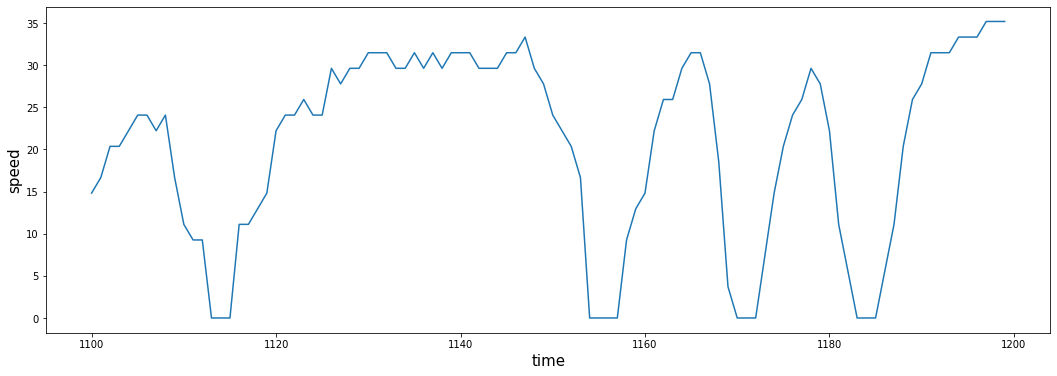

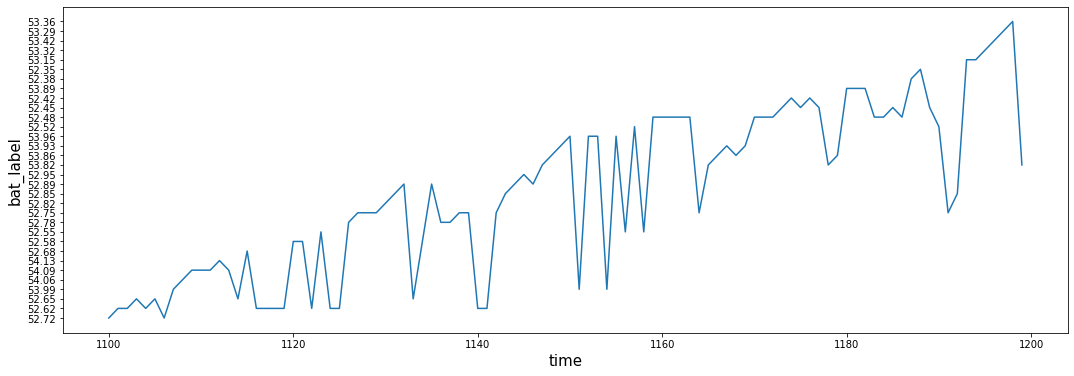

In [29]:
#import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure(figsize = (18,6))
plt.plot(df["speed"][1100:1200])
plt.xlabel('time',fontsize=15)
plt.ylabel('speed',fontsize=15)
plt.show()

plt.figure(figsize = (18,6))
plt.plot(df["main_bat"][1100:1200])
plt.xlabel('time',fontsize=15)
plt.ylabel('bat_label',fontsize=15)
plt.show()

In [30]:
df[1100:1200]

,main_bat,moment_time,speed,altitude,ride_id
1100,52.72,"Mar 24, 2021 @ 20:15:51",14.82,895.2,77139.0
1101,52.62,"Mar 24, 2021 @ 20:15:52",16.67,895.1,77139.0
1102,52.62,"Mar 24, 2021 @ 20:15:53",20.37,894.6,77139.0
1103,52.65,"Mar 24, 2021 @ 20:15:54",20.37,894.5,77139.0
1104,52.62,"Mar 24, 2021 @ 20:15:55",22.22,894.4,77139.0
...,...,...,...,...,...
1195,53.32,"Mar 24, 2021 @ 20:17:45",33.34,882.3,77139.0
1196,53.42,"Mar 24, 2021 @ 20:17:46",33.34,882.4,77139.0
1197,53.29,"Mar 24, 2021 @ 20:17:47",35.19,882.7,77139.0
1198,53.36,"Mar 24, 2021 @ 20:17:48",35.19,883.0,77139.0


In [31]:
#df = df.fillna(0)
#df

In [32]:
single_len = len(group_single)
print(single_len)
len(group_single)

347


347

## Change the 'index' in group[index] below to visualise and print group values

In [33]:
group_debug_single[5]

array([[47.45000000000002, 'Mar 15, 2021 @ 11:26:14', 7.41, 0.0, 76843.0],
       [47.030000000000015, 'Mar 15, 2021 @ 11:26:15', 5.56,
        -0.2999999999999545, 76843.0],
       [46.68000000000002, 'Mar 15, 2021 @ 11:26:16', 5.56,
        -0.6000000000000227, 76843.0],
       [46.660000000000025, 'Mar 15, 2021 @ 11:26:17', 7.41,
        -1.2999999999999545, 76843.0],
       [46.660000000000025, 'Mar 15, 2021 @ 11:26:18', 7.41,
        -1.6000000000000227, 76843.0],
       [46.68000000000003, 'Mar 15, 2021 @ 11:26:19', 9.26,
        -1.7000000000000455, 76843.0],
       [46.69500000000002, 'Mar 15, 2021 @ 11:26:20', 11.11,
        -2.2999999999999545, 76843.0],
       [46.71000000000002, 'Mar 15, 2021 @ 11:26:21', 14.82,
        -2.6000000000000227, 76843.0],
       [47.43000000000002, 'Mar 15, 2021 @ 11:26:22', 16.67,
        -2.7999999999999545, 76843.0],
       [48.18500000000002, 'Mar 15, 2021 @ 11:26:23', 16.67,
        -2.7999999999999545, 76843.0],
       [47.43000000000002, 

In [34]:
group_single[5]

array([[47.45000000000002, 7.41, 0.0],
       [47.030000000000015, 5.56, -0.2999999999999545],
       [46.68000000000002, 5.56, -0.6000000000000227],
       [46.660000000000025, 7.41, -1.2999999999999545],
       [46.660000000000025, 7.41, -1.6000000000000227],
       [46.68000000000003, 9.26, -1.7000000000000455],
       [46.69500000000002, 11.11, -2.2999999999999545],
       [46.71000000000002, 14.82, -2.6000000000000227],
       [47.43000000000002, 16.67, -2.7999999999999545],
       [48.18500000000002, 16.67, -2.7999999999999545],
       [47.43000000000002, 20.37, -3.2000000000000455],
       [46.660000000000025, 22.22, -3.3999999999999773],
       [46.68000000000003, 22.22, -3.3999999999999773],
       [46.78000000000003, 24.08, -2.6000000000000227],
       [46.93000000000002, 24.08, -2.2000000000000455],
       [47.58500000000002, 25.93, -0.39999999999997726],
       [48.190000000000026, 25.93, 1.7000000000000455],
       [48.20500000000003, 25.93, 2.5],
       [47.87000000000003

In [35]:
len(group_single)

347

In [36]:
#for idx, single_chunks in enumerate(group_single):
    #print(single_chunks)
    #group_check_debug = group_debug_single[idx]
    #group_check = single_chunks
    #print(group_debug[16])
    #plt.figure(figsize = (12,4))
    #plt.plot(group_check)
    #plt.xlabel('time',fontsize=15)
    #plt.ylabel('speed',fontsize=15)
    #plt.show()
    #print(group_check)
    

In [37]:
os.chdir("../DoublesA")
group_double = list()
group_debug_double = list()

In [38]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
files_csv

['77089_battery_load_analysis_data (1).csv',
 '77067_battery_load_analysis_data.csv',
 '77131_battery_load_analysis_data.csv',
 '76713_battery_load_analysis_data.csv',
 '76974_battery_load_analysis_data.csv',
 '76935_battery_load_analysis_data.csv',
 '76934_battery_load_analysis_data.csv',
 '76733_battery_load_analysis_data.csv',
 '77129_battery_load_analysis_data (1).csv',
 '77160_battery_load_analysis_data.csv',
 '76975_battery_load_analysis_data.csv',
 '77183_battery_load_analysis_data.csv',
 '77186_battery_load_analysis_data.csv',
 '77007_battery_load_analysis_data.csv',
 '77072_battery_load_analysis_data.csv',
 '76955_battery_load_analysis_data.csv',
 '77161_battery_load_analysis_data.csv',
 '76956_battery_load_analysis_data.csv',
 '77006_battery_load_analysis_data.csv']

In [39]:
iterfiles = iter(files_csv)
df = pd.read_csv(files_csv[0], usecols=["moment_time", "ride_id", "main_bat", "speed", "altitude"])

In [40]:
df

,main_bat,moment_time,speed,altitude,ride_id
0,start_main_bat,NaN,NaN,NaN,NaN
1,end_main_bat,NaN,NaN,NaN,NaN
2,distance,NaN,NaN,NaN,NaN
3,47.78,"Mar 23, 2021 @ 18:38:20",255.00,-1.0,77089.0
4,47.72,"Mar 23, 2021 @ 18:38:20",255.00,-1.0,77089.0
...,...,...,...,...,...
9998,46.31,"Mar 23, 2021 @ 19:06:29",12.96,917.9,77089.0
9999,46.27,"Mar 23, 2021 @ 19:06:29",12.96,917.9,77089.0
10000,46.31,"Mar 23, 2021 @ 19:06:29",12.96,917.9,77089.0
10001,46.31,"Mar 23, 2021 @ 19:06:29",12.96,917.9,77089.0


In [41]:
df = df.drop([0,1,2])
df = df.reset_index()
df=df.drop('index', axis = 1)
t = df.groupby(by="moment_time")
keys = list(t.groups.keys())
df = frac_chunk_dataframe(files_csv[0], t, keys, df_structure)
mean_speed = (mean_speed + df["speed"].mean())/2
#df["altitude"] = df["altitude"].diff()
add_chunk_to_group_double(df)

###############
*******
*******
Unwanted:::: 0 77089_battery_load_analysis_data (1).csv
*******
###############


In [42]:
next(iterfiles)
for filename in iterfiles:
    print(filename)
    #print(df.head())
    df_next = pd.read_csv(filename, usecols=["moment_time", "ride_id", "main_bat", "speed", "altitude"])
    df_next = df_next.drop([0,1,2])
    df_next = df_next.reset_index()
    df_next=df_next.drop('index', axis = 1)
    
    t = df_next.groupby(by="moment_time")
    keys = list(t.groups.keys())
    df_next = frac_chunk_dataframe(filename, t, keys, df_structure)
    
    mean_speed = (mean_speed + df_next["speed"].mean())/2
    df = df.append(df_next, ignore_index = True) #Satish Added this line to see values in df
    #df_next["altitude"] = df_next["altitude"].diff()
    add_chunk_to_group_double(df_next)
    #print(len(group_double))
    #print("File:", filename)
    #print("df_next):", df_next)
print ("end")

77067_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 77067_battery_load_analysis_data.csv
*******
###############
77131_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 77131_battery_load_analysis_data.csv
*******
###############
76713_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76713_battery_load_analysis_data.csv
*******
###############
76974_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76974_battery_load_analysis_data.csv
*******
###############
76935_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76935_battery_load_analysis_data.csv
*******
###############
76934_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76934_battery_load_analysis_data.csv
*******
###############
76733_battery_load_analysis_data.csv
###############
*******
*******
Unwanted:::: 0 76733_battery_load_analysis_data.csv
*******
#

In [43]:
#mean_double_speed = df["speed"].mean()

#df["speed"] = df["speed"].rolling(window=3).mean()
#df["main_bat"] = df["main_bat"].rolling(window=5).mean()
bat_label = df["main_bat"].astype(float)
bat_label = bat_label.round()
#bat_label


In [44]:
bat_label

0         NaN
1        48.0
2        48.0
3        48.0
4        48.0
         ... 
13529    48.0
13530    48.0
13531    48.0
13532    48.0
13533    48.0
Name: main_bat, Length: 13534, dtype: float64

### Change the range in plt.plot(df["speed"][0:1000]) and plt.plot(df["main_bat"][0:1000]) to visualize values at different time index¶


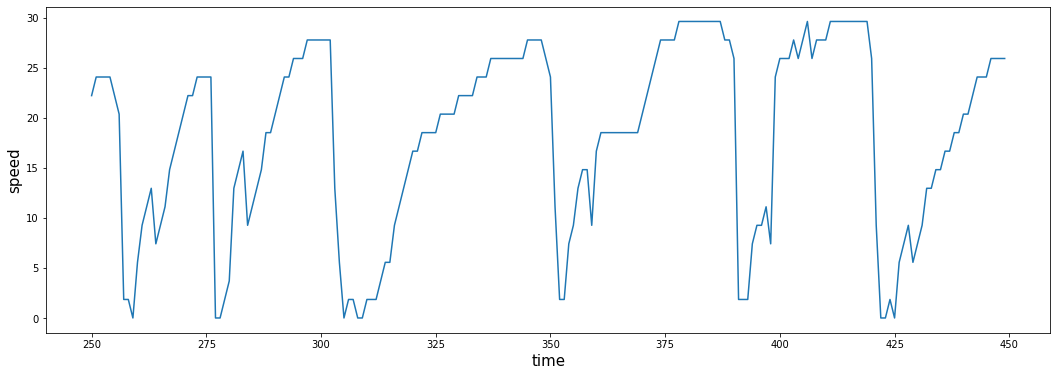

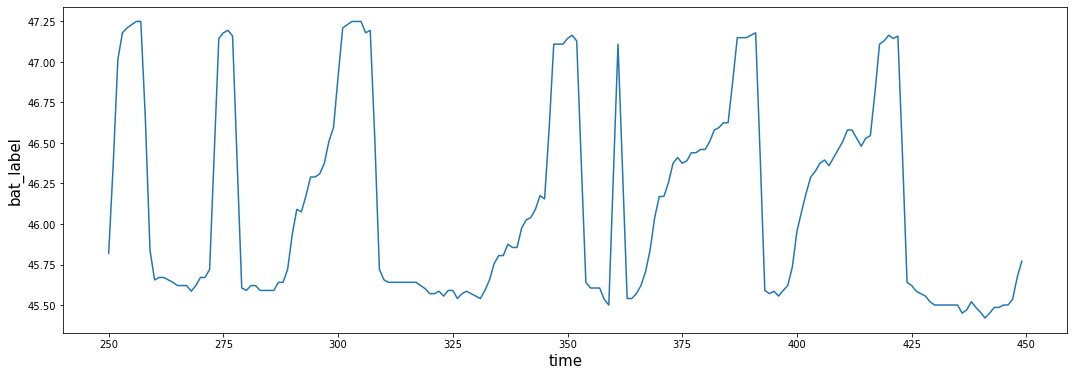

In [45]:
#import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure(figsize = (18,6))
plt.plot(df["speed"][250:450])
plt.xlabel('time',fontsize=15)
plt.ylabel('speed',fontsize=15)
plt.show()

plt.figure(figsize = (18,6))
plt.plot(df["main_bat"][250:450])
plt.xlabel('time',fontsize=15)
plt.ylabel('bat_label',fontsize=15)
plt.show()

In [46]:
#df = df.fillna(0)
#df[0:50]
#df[300:350]

In [47]:
total_len = len(group_single) + len(group_double)
#double_len = total_len - single_len
double_len = len(group_double)
double_len

414

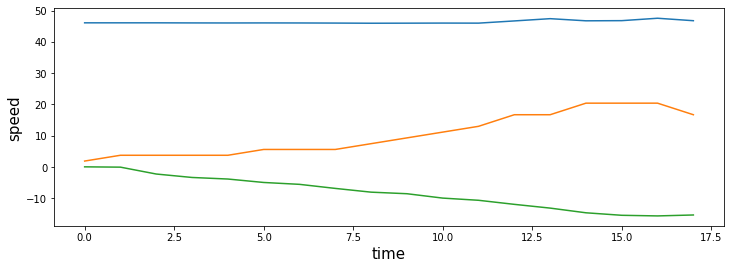

[[46.07 1.85 0.0]
 [46.07000000000001 3.7 -0.10000000000002274]
 [46.07000000000001 3.7 -2.300000000000068]
 [46.040000000000006 3.7 -3.3999999999999773]
 [46.025000000000006 3.7 -3.8999999999999773]
 [46.040000000000006 5.56 -5.0]
 [46.025000000000006 5.56 -5.600000000000023]
 [45.99000000000001 5.56 -6.899999999999977]
 [45.94000000000001 7.41 -8.100000000000023]
 [45.96000000000001 9.26 -8.600000000000023]
 [45.99000000000001 11.11 -10.0]
 [45.97000000000001 12.96 -10.700000000000045]
 [46.67500000000001 16.67 -12.0]
 [47.40000000000002 16.67 -13.200000000000045]
 [46.71500000000002 20.37 -14.700000000000045]
 [46.76500000000002 20.37 -15.5]
 [47.535000000000025 20.37 -15.700000000000045]
 [46.74500000000002 16.67 -15.399999999999977]]


In [48]:
#***************************
#Change the 'index' in group[index] in the line below to visualise and print group values
#***************************
group_check = group_double[0]
plt.figure(figsize = (12,4))
plt.plot(group_check)
plt.xlabel('time',fontsize=15)
plt.ylabel('speed',fontsize=15)
plt.show()

#plt.figure(figsize = (18,6))
#plt.plot(df["main_bat"][500:2000])
#plt.xlabel('time',fontsize=15)
#plt.ylabel('bat_label',fontsize=15)
#plt.show()
print(group_check)

# FEATURE SCALING

In [49]:
#mean_speed = (mean_single_speed + mean_double_speed)/2
#for idx in range(len(group)):
#    for ids in range(len(group[idx])):
#        group[idx][ids][0] = float(group[idx][ids][0])/48.0
#        group[idx][ids][1] = float(group[idx][ids][1])/mean_speed

In [50]:
#scaler = StandardScaler()
#scaler = scaler.fit(train[])
#train = scaler.transform(train)
#test = scaler.transform(test)

# CREATING OUTPUT FILE

In [51]:
target_single = pd.DataFrame(0, index=np.arange(single_len), columns=["label"])
#target_single

In [52]:
target_double = pd.DataFrame(1, index=np.arange(double_len), columns=["label"])
#target_double

In [53]:
target = target_single.append(target_double, ignore_index = True)
#target

# PADDING THINGS PROCEED

In [54]:
#group

In [55]:
len_group = []
for one_group in group_single:
    len_group.append(len(one_group))
pd.Series(len_group).describe()

count    347.000000
mean      12.466859
std        6.747376
min        4.000000
25%        8.000000
50%       11.000000
75%       15.000000
max       40.000000
dtype: float64

In [56]:
#single_padding_len = pd.Series(len_group).describe().values[7]

In [57]:
from collections import Counter


In [58]:
counter = Counter(len_group)
all_values = counter.keys()
single_padding_len = max(all_values)
single_padding_len

40

In [59]:
len_group = []
for one_group in group_double:
    len_group.append(len(one_group))
pd.Series(len_group).describe()

count    414.000000
mean      14.855072
std        9.432737
min        4.000000
25%        8.000000
50%       13.000000
75%       18.000000
max       62.000000
dtype: float64

In [60]:
#doubles_padding_len = pd.Series(len_group).describe().values[7]

In [61]:
counter = Counter(len_group)
all_values = counter.keys()
doubles_padding_len = max(all_values)

In [62]:
doubles_padding_len

62

In [63]:
counter

Counter({4: 9,
         5: 35,
         6: 24,
         7: 24,
         8: 17,
         9: 26,
         10: 24,
         11: 13,
         12: 26,
         13: 17,
         14: 30,
         15: 13,
         16: 20,
         17: 20,
         18: 13,
         19: 12,
         20: 10,
         21: 9,
         22: 13,
         23: 10,
         24: 6,
         25: 2,
         26: 3,
         27: 2,
         28: 3,
         29: 2,
         30: 3,
         31: 5,
         34: 4,
         36: 2,
         37: 1,
         38: 2,
         39: 1,
         40: 2,
         41: 2,
         44: 1,
         45: 1,
         48: 1,
         51: 1,
         52: 2,
         53: 1,
         57: 1,
         62: 1})

In [64]:
pad_len = max(single_padding_len, doubles_padding_len)
pad_len = pad_len

In [65]:
pad_len

62

In [66]:
sequences_single = group_single
#sequences_single

In [67]:
#Padding the sequence with the values in last row to max length
to_pad = pad_len
new_seq = []
for one_seq in sequences_single:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    #print(last_val)
    n = to_pad - len_one_seq
    #print(n)
   
    to_concat = np.repeat([0,0,0], n).reshape(3, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_single = np.stack(new_seq)

#truncate the sequence to length 60
from keras.preprocessing import sequence
seq_len = pad_len
final_seq_single=sequence.pad_sequences(final_seq_single, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [68]:
#final_seq_single

In [69]:
sequences_double = group_double
sequences_double

[array([[46.07, 1.85, 0.0],
        [46.07000000000001, 3.7, -0.10000000000002274],
        [46.07000000000001, 3.7, -2.300000000000068],
        [46.040000000000006, 3.7, -3.3999999999999773],
        [46.025000000000006, 3.7, -3.8999999999999773],
        [46.040000000000006, 5.56, -5.0],
        [46.025000000000006, 5.56, -5.600000000000023],
        [45.99000000000001, 5.56, -6.899999999999977],
        [45.94000000000001, 7.41, -8.100000000000023],
        [45.96000000000001, 9.26, -8.600000000000023],
        [45.99000000000001, 11.11, -10.0],
        [45.97000000000001, 12.96, -10.700000000000045],
        [46.67500000000001, 16.67, -12.0],
        [47.40000000000002, 16.67, -13.200000000000045],
        [46.71500000000002, 20.37, -14.700000000000045],
        [46.76500000000002, 20.37, -15.5],
        [47.535000000000025, 20.37, -15.700000000000045],
        [46.74500000000002, 16.67, -15.399999999999977]], dtype=object),
 array([[45.96000000000002, 11.11, 0.0],
        [45.925

In [70]:
#Padding the sequence with the values in last row to max length
to_pad = pad_len
new_seq = []
for one_seq in sequences_double:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad - len_one_seq
    #print(n)
    to_concat = np.repeat([0,0,0], n).reshape(3, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_double = np.stack(new_seq)

#truncate the sequence to length 60
from keras.preprocessing import sequence
seq_len = pad_len
final_seq_double=sequence.pad_sequences(final_seq_double, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [71]:
#Disable plotting chunks for now. Saish
for idx, single_chunks in enumerate(final_seq_single):
    group_check_debug = group_debug_single[idx]
    group_check = single_chunks
    plt.figure(figsize = (12,4))
    plt.plot(group_check)
    plt.xlabel('time',fontsize=15)
    plt.ylabel('speed',fontsize=15)
    plt.show()
    print(idx)
    print(group_check_debug)

Output hidden; open in https://colab.research.google.com to view.

In [72]:
#Disable plotting chunks for now. Saish
for idx, double_chunks in enumerate(final_seq_double):
    group_check_debug = group_debug_double[idx]
    group_check = double_chunks
    plt.figure(figsize = (12,4))
    plt.plot(group_check)
    plt.xlabel('time',fontsize=15)
    plt.ylabel('speed',fontsize=15)
    plt.show()
    print(group_check_debug)

Output hidden; open in https://colab.research.google.com to view.

In [73]:
final_seq_double.shape

(414, 62, 3)

In [74]:
final_seq_single.shape


(347, 62, 3)

In [75]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [76]:
final_seq_single.shape

(347, 62, 3)

In [77]:
single_len

347

In [78]:
int(0.90*double_len)

372

In [79]:
validation_start = 0.70
validation_end = 0.85

In [80]:
train = np.vstack((final_seq_single[0:int(validation_start*single_len)], final_seq_double[0:int(validation_start*double_len)]))

In [81]:
validation = np.vstack((final_seq_single[int(validation_start*single_len):int(validation_end*single_len)], final_seq_double[int(validation_start*double_len):int(validation_end*double_len)]))

In [82]:
test = np.vstack((final_seq_single[int(validation_end*single_len):single_len], final_seq_double[int(validation_end*double_len):double_len]))

In [83]:
train.shape[0]

531

In [84]:
#target

In [85]:
train_target = np.vstack((target_single[0:int(validation_start*single_len)], target_double[0:int(validation_start*double_len)]))

In [86]:
validation_target = np.vstack((target_single[int(validation_start*single_len):int(validation_end*single_len)], target_double[int(validation_start*double_len):int(validation_end*double_len)]))

In [87]:
test_target = np.vstack((target_single[int(validation_end*single_len):single_len], target_double[int(validation_end*double_len):double_len]))

In [88]:
test_target.shape

(116, 1)

In [89]:
#validation_size_label = 10
#test_size_label = 5

In [90]:
#train = np.vstack((final_seq[0:single_len-validation_size_label], final_seq[single_len:total_len-validation_size_label]))

In [91]:
#validation = np.vstack((final_seq[single_len-validation_size_label:single_len-test_size_label], final_seq[total_len-validation_size_label:total_len-test_size_label]))
#test = np.vstack((final_seq[single_len-test_size_label:single_len], final_seq[total_len-test_size_label:total_len]))
#train_target = np.vstack((target[0:single_len-validation_size_label], target[single_len:total_len-validation_size_label]))
#validation_target = np.vstack((target[single_len-validation_size_label:single_len-test_size_label], target[total_len-validation_size_label:total_len-test_size_label]))
#test_target = np.vstack((target[single_len-test_size_label:single_len], target[total_len-test_size_label:total_len]))

In [92]:
#train = final_seq[0:120]
#f = final_seq[350:361]
#test = final_seq[0:50]

#train_target = target[0:350]
#validation_target = target[350:361]
#test_target = target[0:50]

In [93]:
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

train_target = np.array(train_target)
#train_target = (train_target+1)/2

validation_target = np.array(validation_target)
#validation_target = (validation_target+1)/2

test_target = np.array(test_target)
#test_target = (test_target+1)/2

# Plotting padded Data

In [94]:
#***************************
#Change the 'index' in group[index] in the line below to visualise and print group values
#***************************
#group_check = train[0]
#plt.figure(figsize = (12,4))
#plt.plot(group_check)
#plt.xlabel('time',fontsize=15)
#plt.ylabel('speed',fontsize=15)
#plt.show()

#plt.figure(figsize = (18,6))
#plt.plot(df["main_bat"][500:2000])
#plt.xlabel('time',fontsize=15)
#plt.ylabel('bat_label',fontsize=15)
#plt.show()
#print(group_check)

# Standard Scaler Two

In [95]:
#scaler = StandardScaler()
#scaler = scaler.fit(train)
#train = scaler.transform(train)
#test = scaler.transform(test)

In [96]:
tf.keras.backend.clear_session()

In [97]:
from keras.layers import Dropout

In [98]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=len(train), kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 3]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(len(train), return_sequences=True, input_shape=(seq_len,3))),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(len(train), return_sequences=True, input_shape=(seq_len,3))),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(len(train), input_shape=(seq_len,3))),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 531)         8496      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 1062)        4515624   
_________________________________________________________________
dropout (Dropout)            (None, None, 1062)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 1062)        6771312   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 1062)        0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1062)              6771312   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1062)              0

In [99]:
#model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=len(train), kernel_size=5,
#                      strides=1, padding="causal",
#                      activation="relu",
#                      input_shape=[None, 3])])

In [100]:
#model.add(tf.keras.layers.Bidirectional(LSTM(len(train), return_sequences=True, input_shape=(seq_len,3))))
#model.add(Dropout(0.2)) 
#model.add(tf.keras.layers.Bidirectional(LSTM(len(train), input_shape=(seq_len,3))))
#model.add(Dropout(0.2)) 
#model.add(Dense(1, activation='sigmoid'))
#model.summary()

In [101]:
print(train.shape)
print(validation.shape)
print(test.shape)

(531, 62, 3)
(114, 62, 3)
(116, 62, 3)


In [102]:
train.shape

(531, 62, 3)

In [103]:
adam = Adam(lr=0.000001)  #Note_Satish_change epochs=15
from keras.optimizers import SGD
#opt = SGD(lr=0.1)
#model.add(tf.keras.layers.Dense(8, input_shape=(seq_len,2)))
#model.add(Dropout(0.2))
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=0)
model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
model.fit(train, train_target, epochs=200, batch_size=16, callbacks=[chk], validation_data=(validation,validation_target))
#model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])
#model.fit(train, train_target, epochs=50, batch_size=20, callbacks=[chk], validation_data=(validation,validation_target))

Epoch 1/200
34/34 [==============================] - 21s 309ms/step - loss: 0.2498 - accuracy: 0.4916 - val_loss: 0.2494 - val_accuracy: 0.6140


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 2/200
34/34 [==============================] - 8s 228ms/step - loss: 0.2467 - accuracy: 0.5625 - val_loss: 0.2489 - val_accuracy: 0.5439
Epoch 3/200
34/34 [==============================] - 8s 229ms/step - loss: 0.2450 - accuracy: 0.5659 - val_loss: 0.2490 - val_accuracy: 0.5439
Epoch 4/200
34/34 [==============================] - 8s 229ms/step - loss: 0.2446 - accuracy: 0.5487 - val_loss: 0.2493 - val_accuracy: 0.5439
Epoch 5/200
34/34 [==============================] - 8s 230ms/step - loss: 0.2441 - accuracy: 0.5496 - val_loss: 0.2494 - val_accuracy: 0.5439
Epoch 6/200
34/34 [==============================] - 8s 230ms/step - loss: 0.2456 - accuracy: 0.5412 - val_loss: 0.2497 - val_accuracy: 0.5439
Epoch 7/200
34/34 [==============================] - 8s 229ms/step - loss: 0.2396 - accuracy: 0.5638 - val_loss: 0.2502 - val_accuracy: 0.5439
Epoch 8/200
34/34 [==============================] - 8s 230ms/step - loss: 0.2415 - accuracy: 0.5690 - val_loss: 0.2502 - val_accuracy: 0.5789

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 63/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1941 - accuracy: 0.7416 - val_loss: 0.2603 - val_accuracy: 0.6228
Epoch 64/200
34/34 [==============================] - 8s 228ms/step - loss: 0.1922 - accuracy: 0.7222 - val_loss: 0.2601 - val_accuracy: 0.6140
Epoch 65/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1843 - accuracy: 0.7739 - val_loss: 0.2590 - val_accuracy: 0.6228
Epoch 66/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1806 - accuracy: 0.7647 - val_loss: 0.2590 - val_accuracy: 0.6316


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 67/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1952 - accuracy: 0.7448 - val_loss: 0.2585 - val_accuracy: 0.6228
Epoch 68/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1841 - accuracy: 0.7653 - val_loss: 0.2567 - val_accuracy: 0.6316
Epoch 69/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1867 - accuracy: 0.7479 - val_loss: 0.2566 - val_accuracy: 0.6404


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 70/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1880 - accuracy: 0.7535 - val_loss: 0.2555 - val_accuracy: 0.6404
Epoch 71/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1931 - accuracy: 0.7420 - val_loss: 0.2554 - val_accuracy: 0.6404
Epoch 72/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1881 - accuracy: 0.7328 - val_loss: 0.2551 - val_accuracy: 0.6579


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 73/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1811 - accuracy: 0.7635 - val_loss: 0.2540 - val_accuracy: 0.6491
Epoch 74/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1751 - accuracy: 0.7460 - val_loss: 0.2526 - val_accuracy: 0.6404
Epoch 75/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1850 - accuracy: 0.7513 - val_loss: 0.2520 - val_accuracy: 0.6316
Epoch 76/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1815 - accuracy: 0.7548 - val_loss: 0.2521 - val_accuracy: 0.6404
Epoch 77/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1939 - accuracy: 0.7305 - val_loss: 0.2527 - val_accuracy: 0.6404
Epoch 78/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1826 - accuracy: 0.7511 - val_loss: 0.2511 - val_accuracy: 0.6404
Epoch 79/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1820 - accuracy: 0.7500 - val_loss: 0.2507 - val_accuracy:

INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 83/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1885 - accuracy: 0.7367 - val_loss: 0.2461 - val_accuracy: 0.6491
Epoch 84/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1678 - accuracy: 0.7782 - val_loss: 0.2463 - val_accuracy: 0.6579
Epoch 85/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1755 - accuracy: 0.7720 - val_loss: 0.2426 - val_accuracy: 0.6579
Epoch 86/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1832 - accuracy: 0.7458 - val_loss: 0.2422 - val_accuracy: 0.6667
Epoch 87/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1769 - accuracy: 0.7589 - val_loss: 0.2425 - val_accuracy: 0.6579
Epoch 88/200
34/34 [==============================] - 8s 228ms/step - loss: 0.1750 - accuracy: 0.7764 - val_loss: 0.2403 - val_accuracy: 0.6754


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 89/200
34/34 [==============================] - 8s 232ms/step - loss: 0.1745 - accuracy: 0.7754 - val_loss: 0.2450 - val_accuracy: 0.6491
Epoch 90/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1637 - accuracy: 0.7926 - val_loss: 0.2402 - val_accuracy: 0.6842


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 91/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1795 - accuracy: 0.7685 - val_loss: 0.2376 - val_accuracy: 0.6754
Epoch 92/200
34/34 [==============================] - 8s 228ms/step - loss: 0.1666 - accuracy: 0.7738 - val_loss: 0.2432 - val_accuracy: 0.6316
Epoch 93/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1696 - accuracy: 0.7582 - val_loss: 0.2368 - val_accuracy: 0.6667
Epoch 94/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1771 - accuracy: 0.7673 - val_loss: 0.2350 - val_accuracy: 0.6667
Epoch 95/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1545 - accuracy: 0.8092 - val_loss: 0.2363 - val_accuracy: 0.7105


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 96/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1605 - accuracy: 0.7991 - val_loss: 0.2312 - val_accuracy: 0.6842
Epoch 97/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1623 - accuracy: 0.7633 - val_loss: 0.2315 - val_accuracy: 0.7105
Epoch 98/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1642 - accuracy: 0.7762 - val_loss: 0.2275 - val_accuracy: 0.7193


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 99/200
34/34 [==============================] - 8s 232ms/step - loss: 0.1616 - accuracy: 0.7811 - val_loss: 0.2365 - val_accuracy: 0.7018
Epoch 100/200
34/34 [==============================] - 8s 228ms/step - loss: 0.1649 - accuracy: 0.8104 - val_loss: 0.2261 - val_accuracy: 0.7193
Epoch 101/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1628 - accuracy: 0.7949 - val_loss: 0.2282 - val_accuracy: 0.7105
Epoch 102/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1669 - accuracy: 0.7952 - val_loss: 0.2271 - val_accuracy: 0.7193
Epoch 103/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1509 - accuracy: 0.8113 - val_loss: 0.2313 - val_accuracy: 0.6842
Epoch 104/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1551 - accuracy: 0.7891 - val_loss: 0.2221 - val_accuracy: 0.7281


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 105/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1648 - accuracy: 0.7875 - val_loss: 0.2232 - val_accuracy: 0.7193
Epoch 106/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1504 - accuracy: 0.8153 - val_loss: 0.2313 - val_accuracy: 0.6842
Epoch 107/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1619 - accuracy: 0.7934 - val_loss: 0.2207 - val_accuracy: 0.7368


INFO:tensorflow:Assets written to: best_model.pkl/assets


INFO:tensorflow:Assets written to: best_model.pkl/assets


Epoch 108/200
34/34 [==============================] - 8s 231ms/step - loss: 0.1477 - accuracy: 0.8218 - val_loss: 0.2348 - val_accuracy: 0.6667
Epoch 109/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1657 - accuracy: 0.7887 - val_loss: 0.2208 - val_accuracy: 0.7368
Epoch 110/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1486 - accuracy: 0.8142 - val_loss: 0.2381 - val_accuracy: 0.6667
Epoch 111/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1476 - accuracy: 0.8191 - val_loss: 0.2209 - val_accuracy: 0.7193
Epoch 112/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1525 - accuracy: 0.8007 - val_loss: 0.2244 - val_accuracy: 0.7018
Epoch 113/200
34/34 [==============================] - 8s 230ms/step - loss: 0.1452 - accuracy: 0.8315 - val_loss: 0.2208 - val_accuracy: 0.7105
Epoch 114/200
34/34 [==============================] - 8s 229ms/step - loss: 0.1451 - accuracy: 0.8338 - val_loss: 0.2298 - val_ac

In [104]:
from sklearn.metrics import accuracy_score
test_preds = model.predict_classes(test)
accuracy_score(test_target, test_preds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8103448275862069

In [105]:
test_preds

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
    

In [106]:
test_target

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    